In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.reset_defaults()
sns.set_theme(style='whitegrid')

In [1]:
def bench(source='std', n=2**20, q=2**20, cc='clang++', latency=False, make=False):
    if make:
        !make {source}
    else:
        !{cc} -std=c++17 -O3 -march=native -D N={n} {'-D LATENCY' if latency else ''} {source}.cc -o run
    res = !./run {n} {q}
    duration = float(res[0].split()[0])
    check = int(res[1])
    print(f'{source:>18} {cc:<7} {n:<7} {q:<7} {check:10} {duration}')
    return duration

In [3]:
def plot(title=None, ylabel=None, path=None, ch=None, legend=True, ylim=None):
    if ch:
        lines = [
            (2**13, "32K"),
            (2**17, "512K"),
            (2**20, "4M"),
        ]

        for x, t in lines:
            plt.text(x * 1.2, ch, t)
            plt.axvline(x=x, color='black', linestyle='--')

    plt.xscale('log', basex=2)
    plt.xlabel('Array size')

    if ylabel:
        plt.ylabel(ylabel)

    if title:
        plt.title(title, pad=12)

    if legend:
        plt.legend(loc='best')

    plt.ylim(bottom=0, top=ylim)
    plt.margins(0)

    if path:
        fig = plt.gcf()
        fig.savefig(path)
    
    plt.show()

In [14]:
bench('std', q=2**22, cc='g++')
bench('std', q=2**22, cc='clang++')
bench('textbook', q=2**22, cc='g++')
bench('textbook', q=2**22, cc='clang++')

               std g++     1048576 4194304  334323926 363.3
               std clang++ 1048576 4194304  334323926 386.69
          textbook g++     1048576 4194304  334323926 395.87
          textbook clang++ 1048576 4194304  334323926 395.29


395.29

In [15]:
bench('branchless', cc='g++')

        branchless g++     1048576 1048576 1043364677 313.31


313.31

In [16]:
bench('std', n=2**23, q=2**22, cc='clang++')
bench('textbook', n=2**23, q=2**22, cc='clang++')

               std clang++ 8388608 4194304  778587145 865.5
          textbook clang++ 8388608 4194304  778587145 875.21


875.21

In [27]:
bench('textbook', n=2**22, q=2**22, cc='g++')
bench('branchless', n=2**22, q=2**22, cc='g++')
bench('branchless-prefetch', n=2**22, q=2**22, cc='g++')

          textbook g++     4194304 4194304  305940602 748.85
        branchless g++     4194304 4194304  305940602 650.68
branchless-prefetch g++     4194304 4194304  305940602 604.08


604.08

In [34]:
#bench('eytzinger', n=2**22, q=2**22, cc='clang++')
bench('eytzinger-prefetch', n=2**22, q=2**23, cc='g++')
bench('eytzinger-prefetch2', n=2**22, q=2**23, cc='g++')

eytzinger-prefetch g++     4194304 8388608 1404471057 201.94
eytzinger-prefetch2 g++     4194304 8388608 1404471057 192.61


192.61

In [47]:
for source in ['eytzinger', 'eytzinger-fill', 'eytzinger-last']:
    bench(source, n=int(2**12), q=2**20, cc='clang++')

         eytzinger clang++ 4096    1048576 1600616319 28.59
    eytzinger-fill clang++ 4096    1048576 1600616319 31.95
    eytzinger-last clang++ 4096    1048576 1600616319 31.04


In [49]:
for source in ['btree', 'btree-hugepages', 'btree-optimized']:
    bench(source, n=2**23, q=2**20, cc='clang++')

             btree clang++ 8388608 1048576   70931121 153.2
   btree-hugepages clang++ 8388608 1048576   70931121 135.82


In [54]:
for source in ['btree-optimized', 'bplus', 'bplus32', 'bplus-nontemporal']:
    bench(source, n=2**23, q=2**20, cc='clang++')

   btree-optimized clang++ 8388608 1048576   70931121 116.46
             bplus clang++ 8388608 1048576   70931121 79.58
           bplus32 clang++ 8388608 1048576   70931121 86.16
 bplus-nontemporal clang++ 8388608 1048576   70931121 79.61


In [55]:
for source in ['bplus', 'bplus32', 'bplus-nontemporal']:
    bench(source, n=2**25, q=2**23, cc='clang++')

             bplus clang++ 33554432 8388608 1774518850 114.76
           bplus32 clang++ 33554432 8388608 1774518850 103.61
 bplus-nontemporal clang++ 33554432 8388608 1774518850 112.78


In [18]:
bench('bplus', n=2**22, q=2**22, cc='g++')

             bplus g++     4194304 4194304  305940602 86.15


86.15

In [17]:
bench('bplus', n=2**22, q=2**22, cc='clang++')

             bplus clang++ 4194304 4194304  305940602 82.31


82.31

In [5]:
bench('std', cc='g++')

               std 1048576 1048576 1043364677 382.45


382.45

In [5]:
ns = list(int(1.17**k) for k in range(30, 110))

sources1 = [
    'std',
    'branchless',
    'branchless-prefetch',
    'eytzinger',
    'eytzinger-prefetch',
    'eytzinger-prefetch2',
    'eytzinger-last',
    'btree',
    'btree-hugepages',
]

sources2 = [
    'btree-optimized',
    'bplus',
    'bplus32',
    'bplus-nontemporal'
]

results = {}

for source in sources1:
    results[source] = [bench(source, n=n, q=2**22, make=True) for n in ns]

"""
tasks = [
    # source, name, color
    ('std', 'std::lower_bound', 'darkred'),
    ('branchless', 'branchless', 'darkblue'),
    ('eytzinger', 'eytzinger', 'darkgreen'),
    ('eytzinger-prefetch', 'eytzinger (with prefetching)', 'orange'),
    ('btree', 'B-tree (with SIMD)', 'purple'),
    ('btree-hugepages', 'B-tree (with SIMD and huge pages)', 'cyan'),
]

results = [
    [bench(n=n, q=2**22, source=source) for n in ns]
    for source, _, _ in tasks
]
"""

make: 'std' is up to date.
               std clang++ 111     4194304 1067433874 47.97
make: 'std' is up to date.
               std clang++ 129     4194304 2084202863 49.68
make: 'std' is up to date.
               std clang++ 152     4194304 1650086489 50.57
make: 'std' is up to date.
               std clang++ 177     4194304 1093987052 53.4
make: 'std' is up to date.
               std clang++ 208     4194304  849577987 53.92
make: 'std' is up to date.
               std clang++ 243     4194304 1842022031 56.36
make: 'std' is up to date.
               std clang++ 284     4194304   24170984 58.32
make: 'std' is up to date.
               std clang++ 333     4194304 1064724685 59.86
make: 'std' is up to date.
               std clang++ 389     4194304 1049421536 63.24
make: 'std' is up to date.
               std clang++ 456     4194304 1677787291 65.56
make: 'std' is up to date.
               std clang++ 533     4194304 1381557454 68.43
make: 'std' is up to date.
               st

"\ntasks = [\n    # source, name, color\n    ('std', 'std::lower_bound', 'darkred'),\n    ('branchless', 'branchless', 'darkblue'),\n    ('eytzinger', 'eytzinger', 'darkgreen'),\n    ('eytzinger-prefetch', 'eytzinger (with prefetching)', 'orange'),\n    ('btree', 'B-tree (with SIMD)', 'purple'),\n    ('btree-hugepages', 'B-tree (with SIMD and huge pages)', 'cyan'),\n]\n\nresults = [\n    [bench(n=n, q=2**22, source=source) for n in ns]\n    for source, _, _ in tasks\n]\n"

In [8]:
for source in sources2:
    results[source] = [bench(source, n=n, q=2**22) for n in ns]

   btree-optimized clang++ 111     4194304 1067433874 6.54
   btree-optimized clang++ 129     4194304 2084202863 6.49
   btree-optimized clang++ 152     4194304 1650086489 6.31
   btree-optimized clang++ 177     4194304 1093987052 8.39
   btree-optimized clang++ 208     4194304  849577987 7.12
   btree-optimized clang++ 243     4194304 1842022031 6.62
   btree-optimized clang++ 284     4194304   24170984 8.73
   btree-optimized clang++ 333     4194304 1064724685 14.31
   btree-optimized clang++ 389     4194304 1049421536 16.11
   btree-optimized clang++ 456     4194304 1677787291 18.14
   btree-optimized clang++ 533     4194304 1381557454 19.02
   btree-optimized clang++ 624     4194304  485950239 14.17
   btree-optimized clang++ 730     4194304 1743435292 15.88
   btree-optimized clang++ 855     4194304 1980389118 13.05
   btree-optimized clang++ 1000    4194304  929098415 14.38
   btree-optimized clang++ 1170    4194304 1814983758 14.06
   btree-optimized clang++ 1369    4194304  683

In [9]:
import pickle

with open('results.pkl', 'wb') as file:
    pickle.dump(results, file)

In [10]:
latency_std = [bench('std', n=n, q=2**22, latency=True) for n in ns]
latency_bplus = [bench('bplus', n=n, q=2**22, latency=True) for n in ns]

In [ ]:
for i, current in enumerate(tasks):
    for (source, name, color), latencies in list(zip(tasks, results))[:i + 1]:
        plt.plot(ns, latencies, color=color, label=name)
    
    plot('Binary search', 'Latency (ns)', current[0] + '.svg', 1, legend=True)

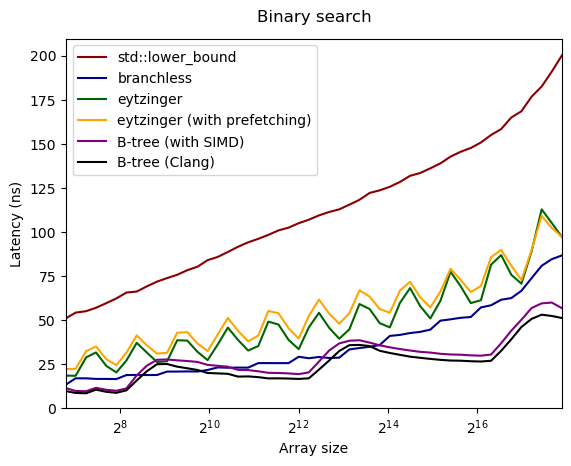

In [118]:
lim = 50
for (source, name, color), latencies in list(zip(tasks, results))[:-1]:
    plt.plot(ns[:lim], latencies[:lim], color=color, label=name)

plt.plot(ns[:lim], btree_clang[:lim], color='black', label='B-tree (Clang)')

plot('Binary search', 'Latency (ns)', 'mini.svg', legend=True)